In [3]:
import os
import torch
import torchvision


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from PIL import Image

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [4]:
n_epochs = 50
batch_size_train = 32# was 64
batch_size_test = 16
learning_rate = 0.01
momentum = 0.1
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
''' 
    NOTES: 
    - it's "No Finding" not "No findings"
    - it's "Pleural_Thickening" not "Pleural_thickening"
    - it's not "Nodule Mass", but rather "Nodule" and "Mass" separately
'''
disease_map = {"Atelectasis" : 0, "Consolidation" : 1, "Infiltration" : 2, "Pneumothorax": 3, "Edema": 4,
               "Emphysema": 5, "Fibrosis": 6, "Effusion" : 7, "Pneumonia" : 8, "Pleural_Thickening" : 9,
               "Cardiomegaly" : 10, "Nodule" : 11, "Mass" : 12, "Hernia" : 13, "No Finding" : 14 }

In [6]:
class GetLoader(torch.utils.data.Dataset):
    def __init__(self, data_root, labels_path, transforms=None):
        
        self.root = data_root
        self.transforms = transforms
    
        f = open(labels_path, 'r')
        datalist = f.readlines()
        f.close()
        
        
        self.len_data = len(datalist)

        self.img_paths = []
        self.img_labels = []
        
        self.cur_img_path = ''

        # csv file format:
        # Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],
        
        # example:
        # 00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
        
        for data in datalist:
            data = data.split(',') # get csv line as list
            self.img_paths.append(data[0]) # image name is first in csv file
            
            diseases = data[1].split('|')
            one_hot = [0] * 15
            for d in diseases:
                hot_index = disease_map[d]
                one_hot[hot_index] = 1
            
            self.img_labels.append(torch.Tensor(one_hot)) # disease type is second in csv file

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)) # .convert('RGB')
        self.cur_img_path = os.path.join(self.root, img_paths)

        if self.transforms is not None:
            for t in self.transforms:
                imgs = t(imgs)

        return imgs, labels
    
    def get_img_path(self):
        return self.cur_img_path

    def __len__(self):
        return self.len_data

In [7]:
# locations from which to grab training / testing data
# image_root_train = os.path.join('.', 'data', 'sorted_for_use', 'train')
# image_root_test = os.path.join('.', 'data', 'sorted_for_use', 'test')

# label_path_train = os.path.join('.', 'data', 'sorted_for_use', 'train.csv')
# label_path_test = os.path.join('.', 'data', 'sorted_for_use', 'test.csv')

image_root_train = os.path.join('.', 'data_subset', 'train')
image_root_test = os.path.join('.', 'data_subset', 'test')

label_path_train = os.path.join('.', 'data_subset', 'train_subset.csv')
label_path_test = os.path.join('.', 'data_subset', 'test_subset.csv') 

print(label_path_train)
print(label_path_test)

# need a train and test dataset object
transforms = [torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()]
dataset_train = GetLoader(image_root_train, label_path_train, transforms=transforms)
dataset_test = GetLoader(image_root_test, label_path_test, transforms=transforms)

# these should just have the new dataset objects in them
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_train, shuffle=True)

print(len(train_loader))
print(len(test_loader))

./data_subset/train_subset.csv
./data_subset/test_subset.csv
71
18


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, n_filters_in, n_filters_out, kernel_size=3, stride=1, padding=0): #k=3, s=2, p=0 for down
        super(ConvBlock, self).__init__()
        ops = []
        
        ops.append(nn.Conv2d(n_filters_in, n_filters_out, kernel_size, padding=padding, stride=stride))
        ops.append(nn.BatchNorm2d(n_filters_out))
        ops.append(nn.ReLU(inplace=True))
        
        self.conv = nn.Sequential(*ops)
        
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = ConvBlock(1, 10, kernel_size=3, stride=2, padding=1) # 1024x1024 -> 512x512
        self.conv2 = ConvBlock(10, 20, kernel_size=3, stride=2, padding=1) # 512x512 -> 256x256
        self.conv3 = ConvBlock(20, 40, kernel_size=3, stride=2, padding=1) # 256x256 -> 128x128
        self.conv4 = ConvBlock(40, 80, kernel_size=3, stride=2, padding=1) # 128x128 -> 64x64
        self.conv5 = ConvBlock(80, 80, kernel_size=3, stride=2, padding=1) # 64x64 -> 32x32
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(80 * 32 * 32, 100)
        self.fc2 = nn.Linear(100, 15)  # changed output to 15 since 15 disease classes
        self.sigmoid = nn.Sigmoid()
    
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Final feature reduction - gradient map goes here
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)
        
        x = self.conv5(x)
        x = self.conv_drop(x)
        
        x = x.view(-1, 20 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
    def get_activations(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [10]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = ConvBlock(1, 10, kernel_size=3, stride=4, padding=0) # 1024x1024 -> 256x256
        self.conv2 = ConvBlock(10, 20, kernel_size=3, stride=4, padding=0) # 256x256 -> 64x64
        self.conv3 = ConvBlock(20, 40, kernel_size=3, stride=4, padding=0) # 64x64 -> 16x16
        self.conv4 = ConvBlock(40, 80, kernel_size=3, stride=2, padding=1) # 16x16 -> 8x8
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(80 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 15)  # changed output to 15 since 15 disease classes
        self.sigmoid = nn.Sigmoid()
    
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Final feature reduction - gradient map goes here
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)
        
        x = self.conv_drop(x)
        
        x = x.view(-1, 80 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
    def get_activations(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [11]:
network = Net()
# cuda requirements
network = torch.nn.DataParallel(network)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
print('Trainable params: {}'.format(sum(p.numel() for p in network.parameters() if p.requires_grad)))

Trainable params: 8289795


In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
outputs = []

In [13]:
def train(epoch):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):  # (output - actual )
        
        if torch.cuda.is_available:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = network(data)
        outputs.append(output)
        
        loss_t = torch.nn.BCELoss()
        loss = loss_t(output, target)
        loss.backward()
        optimizer.step()
        
        #if(batch_idx == 1):
            #print(output)
        
        if batch_idx % log_interval == 0:
#             print('Train Epoch: {} \tLoss: {:.6f}'.format(
#                 epoch, loss.item()))            
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))
    
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results')
            torch.save(optimizer.state_dict(), './results')

In [14]:
test_one = True

In [15]:
def test(test_one):
    
    network.eval()
    test_loss = 0
    correct = 0
    
    num_tested = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if torch.cuda.is_available:
                data, target = data.cuda(), target.cuda()
                
            if batch_idx == 50:
                break;
            else:
                num_tested += len(data)
            
            output = network(data)
            loss_t = torch.nn.BCELoss()
            test_loss += loss_t(output, target).item()
            #print(output)
            pred = output.clone().cpu()
            target = target.cpu()
            #pred[pred > 0.5] = 1
            

            
            for p in pred:
                p = p.data

                for i in range(len(p)):
                    if p[i] > 0.5:
                        p[i] = 1
                    else:
                        p[i] = 0
                torch.tensor(p)
                
#             if test_one:
#                 print("printing correct ones:")
#                 for i in range(pred.shape[0]):
#                     #if torch.equal(pred[i], target[i]):
#                     print("-----------------------")
#                     print(torch.tensor(pred[i] == target.data[i]))
#                     print("output: " + str(output[0]))
#                     print("pred: " + str(pred[0]))
#                     print("target: " + str(target[0]))
#                 print("that's all")
#                 test_one = False
            


            correct = torch.sum(torch.tensor(pred == target)).sum()
        
    test_loss /= num_tested
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, num_tested,
    100. * correct / num_tested))

In [16]:
a = torch.tensor([0.5322, 0.4739, 0.4984, 0.4987, 0.4848, 0.5163, 0.4653, 0.5266, 0.5015,
        0.4888, 0.4641, 0.4660, 0.4884, 0.4615, 0.4721])

for i in range(len(a)):
    if a[i] > 0.5:
        a[i] = 1
    else:
        a[i] = 0
print(a)

tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])


In [17]:
print(torch.cuda.device_count())
torch.cuda.get_device_name(0)
torch.cuda.is_available()

1


True

In [18]:
print("Starting Training")
test(test_one)
for epoch in range(1, n_epochs + 1):
    print("-----------Epoch " + str(epoch) + "----------------")
    train(epoch)
    test(test_one)

Starting Training


/usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test set: Avg. loss: 0.0221, Accuracy: 160/567 (28%)

-----------Epoch 1----------------

Test set: Avg. loss: 0.0122, Accuracy: 302/567 (53%)

-----------Epoch 2----------------

Test set: Avg. loss: 0.0120, Accuracy: 296/567 (52%)

-----------Epoch 3----------------

Test set: Avg. loss: 0.0119, Accuracy: 299/567 (53%)

-----------Epoch 4----------------

Test set: Avg. loss: 0.0118, Accuracy: 294/567 (52%)

-----------Epoch 5----------------

Test set: Avg. loss: 0.0117, Accuracy: 306/567 (54%)

-----------Epoch 6----------------

Test set: Avg. loss: 0.0116, Accuracy: 297/567 (52%)

-----------Epoch 7----------------

Test set: Avg. loss: 0.0115, Accuracy: 290/567 (51%)

-----------Epoch 8----------------

Test set: Avg. loss: 0.0114, Accuracy: 290/567 (51%)

-----------Epoch 9----------------

Test set: Avg. loss: 0.0113, Accuracy: 291/567 (51%)

-----------Epoch 10----------------

Test set: Avg. loss: 0.0114, Accuracy: 300/567 (53%)

-----------Epoch 11----------------

Test se

<Figure size 432x288 with 0 Axes>

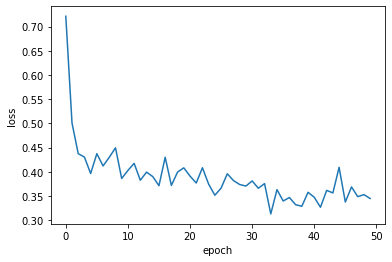

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(train_losses[0:50])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.figure()

<Figure size 432x288 with 0 Axes>

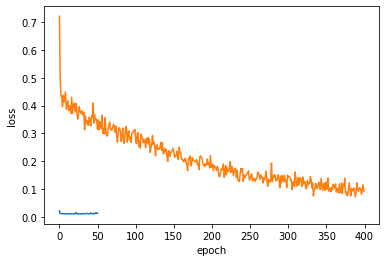

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(test_losses)
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.figure()

<Figure size 432x288 with 0 Axes>

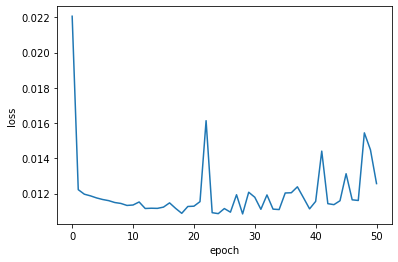

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(test_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.figure()